https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

https://radimrehurek.com/gensim/corpora/wikicorpus.html

https://radimrehurek.com/gensim/wiki.html

https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

https://www.datasciencebytes.com/bytes/2014/12/31/analysis-of-shakespeare-character-speech-topics/
https://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/
https://www.datasciencebytes.com/bytes/2014/11/20/using-topic-modeling-to-find-related-blog-posts/

# Notes 
- Some article content is wiki listings.. remove from dataset
- Some article content is not specific to the POI
- Some article content is repeated across multilte POIs

In [1]:
%matplotlib inline
import re
import nltk
import json
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

In [3]:
from gensim import corpora, models, similarities

In [4]:
from nltk.corpus import stopwords

In [5]:
stopset = set(stopwords.words('english'))

In [6]:
def clean_text(text, lower=True, properNouns=True):
    if not properNouns:
        ttext = tokenize_text(text, lower=False)
        tagged_text = nltk.pos_tag(ttext)
        edited_text = [word for word, tag in tagged_text if tag != 'NNP' and tag != 'NNPS']            
        text =  ' '.join(edited_text)
    if lower:
        text = text.lower()
    text = re.sub('[^a-zA-Z]+', ' ', text)
    return text

In [7]:
def tokenize_text_from_df(df, col='Article_content', out_col='Article_tokens', \
                          lower=True, stopwords=False, stopset=stopset, \
                          properNouns=True):
    df[out_col] = ''
    n_rows, n_cols = df.shape
    for i in np.arange(n_rows):
        raw_text = df[col].iloc[i]
        if type(raw_text) == float:
            continue
        text = clean_text(raw_text, lower, properNouns)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        if stopwords:
            tokens = [w for w in tokens if not w in stopset]
        df[out_col].iloc[i] = tokens
    return df

In [8]:
def tokenize_text(raw_text, lower=True, stopwords=False, stopset=stopset, properNouns=True):
    if type(raw_text) == float:
        return ''
    text = clean_text(raw_text, lower, properNouns)
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    if stopwords:
        tokens = [w for w in tokens if not w in stopset]
    return tokens

In [9]:
datadir = '/Users/klarnemann/Documents/Insight/Insight_project/data'

In [10]:
#poi_df = pd.read_csv('%s/poi_for_nlp.csv' % (datadir), index_col=0)
#poi_df.to_csv('%s/poi_for_nlp.csv' % (datadir))
#poi_df.to_excel('%s/poi_for_nlp.xlsx' % (datadir))

# By city

In [18]:
poi_df = pd.read_excel('%s/all_poi_for_nlp.xlsx' % (datadir), index_col=0)

In [19]:
poi_df.head()

,Name,Location,Article_content
0,Penns Valley Area Historical Museum,"Aaronsburg, Pennsylvania",Valley Forge National Historical Park is the s...
1,Palmetto Island State Park,"Abbeville, Louisiana",Palmetto Island State Park is a recent additio...
2,Abbeville Museum,"Abbeville, Louisiana",Abbeville (French pronunciation: [ab.vil] (lis...
3,Louisiana Military Hall of Fame and Museum,"Abbeville, Louisiana","The landing craft, vehicle, personnel (LCVP) o..."
4,Civil War Earthworks at Tallahatchie Crossing,"Abbeville, Mississippi",The Civil War Earthworks at Tallahatchie Cross...


In [137]:
poi_by_city_df = pd.read_csv('%s/unchecked_poi_by_city_for_nlp.csv' % (datadir), 
                             index_col=0)

In [138]:
poi_by_city_df.head()

,Location,POIs,Article_content
0,"Abbeville, Louisiana",Palmetto Island State Park,Palmetto Island State Park is a recent additio...
1,"Abbeville, Mississippi",Civil War Earthworks at Tallahatchie Crossing,The Civil War Earthworks at Tallahatchie Cross...
2,"Abbeville, South Carolina",Burt-Stark Mansion,"The Burt-Stark Mansion, also known as Armistea..."
3,"Abercrombie, North Dakota",Fort Abercrombie State Historic Site,"Fort Abercrombie, in North Dakota, was an Amer..."
4,"Aberdeen Proving Ground, Maryland","Gunpowder Meetinghouse, Presbury Meetinghouse",Gunpowder Meetinghouse is a historic Methodist...


In [94]:
gps_coord_df = pd.read_excel('%s/gps_lat_long_coordinates.xlsx' % (datadir), index_col=1)
gps_coord_df = gps_coord_df.drop('Unnamed: 0', axis=1)
gps_coord_df.head(3)

,Coords
Location,
"Aaronsburg, Pennsylvania","(40.8997903, -77.4533235)"
"Abbeville, Louisiana","(29.9746502, -92.1342921)"
"Abbeville, Mississippi","(34.5031591, -89.5031368)"


In [139]:
web_df = poi_by_city_df[['Location', 'POIs']];
web_df['Coords'] = gps_coord_df.loc[poi_by_city_df.Location, 'Coords'].values;

In [140]:
web_df.index = web_df.Location.values
web_df = web_df.drop('Location',axis=1)

In [141]:
web_df.head()

,POIs,Coords
"Abbeville, Louisiana",Palmetto Island State Park,"(29.9746502, -92.1342921)"
"Abbeville, Mississippi",Civil War Earthworks at Tallahatchie Crossing,"(34.5031591, -89.5031368)"
"Abbeville, South Carolina",Burt-Stark Mansion,"(34.1779495, -82.3792463)"
"Abercrombie, North Dakota",Fort Abercrombie State Historic Site,"(46.447738, -96.730356)"
"Aberdeen Proving Ground, Maryland","Gunpowder Meetinghouse, Presbury Meetinghouse","(39.4679716, -76.1324354)"


In [144]:
web_df.to_csv('%s/results/information.csv' % (datadir))

## Remove stop words and proper nouns

In [22]:
input_df = tokenize_text_from_df(poi_by_city_df, lower=True, stopwords=True, \
                                     properNouns=False)

In [23]:
print(input_df.shape)
input_df.head()

,Location,POIs,Article_content,Article_tokens
0,"Abbeville, Louisiana",Palmetto Island State Park,Palmetto Island State Park is a recent additio...,"[recent, addition, system, new, state, park, l..."
1,"Abbeville, Mississippi",Civil War Earthworks at Tallahatchie Crossing,The Civil War Earthworks at Tallahatchie Cross...,"[earthwork, earthworks, located, federal, land..."
2,"Abbeville, South Carolina",Burt-Stark Mansion,"The Burt-Stark Mansion, also known as Armistea...","[also, known, site, last, cabinet, members, go..."
3,"Abercrombie, North Dakota",Fort Abercrombie State Historic Site,"Fort Abercrombie, in North Dakota, was an Amer...","[american, fort, established, authority, act, ..."
4,"Aberdeen Proving Ground, Maryland",Gunpowder Meetinghouse\nPresbury Meetinghouse,Gunpowder Meetinghouse is a historic Methodist...,"[historic, church, located, proving, one, room..."


In [24]:
input_df.Article_content.iloc[0]

"Palmetto Island State Park is a recent addition to the Louisiana State Park system. The new state park is located south of Abbeville, Louisiana in Vermilion Parish. The state of Louisiana acquired the property for the park in 1981 but did not begin construction on it with the intent of public use until 2002. State budget constraints and other concerns delayed the park's opening until October, 28, 2010. \nThe park, 1,299 acres (5.26 km2) in size, is noted for its abundance of palmettos,(mostly Dwarf Palmetto) which form a dense understory in the coastal bottomland hardwood forest that predominates here.\nPalmetto Island State Park has a visitor's center which houses a multi-purpose room that can rented for meetings, weddings and other social events. A water playground is located nearby. Guests may stay at one of six two-bedroom cabins nestled in the woods or use any of the park's 95 campsites. There are four picnic pavilions and strategically placed picnic sites for visitors. An aquati

In [25]:
len(input_df.Article_content.iloc[0])

1472

In [27]:
remove_rows = []
for i, val in enumerate(input_df.Article_content):
    if len(val) <= 1:
        remove_rows.append(i)

In [28]:
input_df = input_df.drop(remove_rows)

In [29]:
print(input_df.shape)
input_df.head()

(7224, 4)


,Location,POIs,Article_content,Article_tokens
0,"Abbeville, Louisiana",Palmetto Island State Park,Palmetto Island State Park is a recent additio...,"[recent, addition, system, new, state, park, l..."
1,"Abbeville, Mississippi",Civil War Earthworks at Tallahatchie Crossing,The Civil War Earthworks at Tallahatchie Cross...,"[earthwork, earthworks, located, federal, land..."
2,"Abbeville, South Carolina",Burt-Stark Mansion,"The Burt-Stark Mansion, also known as Armistea...","[also, known, site, last, cabinet, members, go..."
3,"Abercrombie, North Dakota",Fort Abercrombie State Historic Site,"Fort Abercrombie, in North Dakota, was an Amer...","[american, fort, established, authority, act, ..."
4,"Aberdeen Proving Ground, Maryland",Gunpowder Meetinghouse\nPresbury Meetinghouse,Gunpowder Meetinghouse is a historic Methodist...,"[historic, church, located, proving, one, room..."


In [30]:
line_list = input_df['Article_tokens'].tolist()

In [31]:
input_dictionary = corpora.Dictionary(line_list)

In [32]:
once_ids = [tokenid for tokenid, docfreq in input_dictionary.dfs.items() if docfreq == 1]
input_dictionary.filter_tokens(once_ids)
input_dictionary.compactify()

In [33]:
input_corpus = [input_dictionary.doc2bow(words) for words in line_list]
corpora.mmcorpus.MmCorpus.serialize('%s/poi_rm_nnp_rm_stopwords.mm' % (datadir), input_corpus)
tfidf = models.TfidfModel(input_corpus)

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [34]:
lsi = models.lsimodel.LsiModel(corpus=tfidf[input_corpus], id2word=input_dictionary)
lsi.save('%s/poi_rm_nnp_rm_stopwords.lsi' % (datadir))

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [35]:
corpus_lsi = lsi[tfidf[input_corpus]]

In [36]:
matsim = similarities.MatrixSimilarity(lsi[tfidf[input_corpus]])

In [153]:
out_f = '%s/results/matsim_lsi_poi_rm_nnp_rm_stopwords.csv' % (datadir)
#matsim_df = pd.read_csv(out_f, index_col=0)
matsim_df.to_csv(out_f)

In [123]:
matsim_mat = np.array(matsim)
np.fill_diagonal(matsim_mat, 1)
matsim_df = pd.DataFrame(matsim_mat, index=cities, columns=cities)

In [152]:
matsim_df = matsim_df.round(2)

In [ ]:
def recommendations(city, top_n, matsim_df=matsim_df, category_df=category_df):
    cities = np.array(matsim_df.index)
    vals = np.array(matsim_df.loc[city])
    n_cities = len(cities)
    inds = [x for _, x in sorted(zip(vals, np.arange(n_cities)), reverse=True)]
    top_inds = inds[:top_n]
    recommendations = cities[top_inds]
    pois = category_df.POI_names.loc[recommendations]
    inds = ['Input'] + list(np.array(np.arange(1,top_n), dtype=str))
    out_df = pd.DataFrame(np.array([recommendations, pois]).T, 
                          columns=['City', 'Points of Interest'], 
                          index=inds)
    return out_df

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
city = 'Asheville, North Carolina'
#Athens, Georgia
#Auburn, California
#Billings, Montana
#Astoria, Oregon
#Abbeville, Mississippi
#Alexandria, Virginia
#Alpena, Michigan
#Altoona, Pennsylvania
#Amarillo, Texas
#Carlsbad, New Mexico
#Amherst, Massachusetts
#Anadarko, Oklahoma
#Apalachicola, Florida
#Appleton, Wisconsin
# Alamo, Nevada
#Albuquerque, New Mexico
#city = 'Jim Thorpe, Pennsylvania'
recommendations(city, 5)

In [73]:
#matsim.get_similarities(query)

In [122]:
matsim_df.shape

(7224, 7224)

In [124]:
out_f = '%s/results/matsim_lsi_poi_rm_nnp_rm_stopwords.csv' % (datadir)
matsim_df.to_csv(out_f)

### Examine output
word cloud: https://www.jasondavies.com/wordcloud/

In [192]:
pos_tags = []
neg_tags = []
pos_weights = []
neg_weights = []

In [193]:
for i, topic in enumerate(lsi.print_topics(200)):
    pos_tag = False
    neg_tag = False
    for item in topic[1].split(' + '):
        weight, word = item.split('*')
        if not pos_tag:
            if float(weight) > 0:
                pos_tag = True
                pos_tags.append(word[1:-1])
                pos_weights.append(weight)
        if not neg_tag:
            if float(weight) < 0:
                neg_tag = True
                neg_tags.append(word[1:-1])
                neg_weights.append(weight)
        if pos_tag and neg_tag:
            continue

In [200]:
#for word in pos_tags:
#    print(word)

In [199]:
#for word in neg_tags:
#    print(word)

In [203]:
all_words = []
for i, topic in enumerate(lsi.print_topics(200)):
    for item in topic[1].split(' + '):
        weight, word = item.split('*')
        all_words.append(word[1:-1])

### Loads

In [8]:
#city_load_df = pd.read_csv('%s/results/lsi_default_model/load_lsi_poi_rm_nnp_rm_stopwords.csv' % (datadir), index_col=0)

In [40]:
city_load = []
for i, city in enumerate(cities):
    try:
        tmp_load = list(np.array(corpus_lsi[i])[:,1])
        tmp_load = [i] + tmp_load
        city_load.append(tmp_load)
    except:
        continue

In [41]:
city_load_df = pd.DataFrame(np.array(city_load))
city_load_df[0] = cities
city_load_df.columns = ['Location'] + list(np.arange(200))
city_load_df.set_index('Location', inplace=True)
city_load_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Location,,,,,,,,,,,,,,,,,,,,,
"Abbeville, Louisiana",0.151746,0.075846,0.208928,0.007581,-0.025233,0.079220,0.011094,-0.054081,-0.003708,-0.021717,...,0.025998,0.010641,-0.019759,0.031132,-0.006606,0.011762,-0.050583,0.019153,-0.000274,0.009076
"Abbeville, Mississippi",0.048519,0.016074,-0.003145,-0.008716,-0.002472,-0.037736,-0.028134,-0.011363,-0.008655,-0.011950,...,0.001690,-0.009866,-0.005742,-0.009645,-0.001036,0.012822,0.000695,0.015113,0.016554,-0.002576
"Abbeville, South Carolina",0.195767,0.085917,-0.118224,-0.075237,-0.001671,0.030151,-0.179351,-0.004964,0.130961,-0.077277,...,0.003624,0.025291,-0.008479,0.001788,-0.032770,-0.019350,0.030660,0.030630,-0.008145,-0.015102
"Abercrombie, North Dakota",0.149226,0.039002,-0.018424,0.026763,0.044671,-0.177961,-0.177286,-0.179529,-0.195072,-0.205512,...,-0.003402,0.008516,-0.001134,-0.010924,-0.001096,0.008435,-0.012826,-0.008540,0.006852,-0.014178
"Aberdeen Proving Ground, Maryland",0.099567,0.060126,-0.052145,-0.098238,-0.029899,0.015609,-0.032476,0.012735,0.051682,-0.005962,...,0.021031,-0.007298,-0.054761,0.019563,0.023568,-0.022912,0.011090,0.021543,-0.004235,0.012503


In [42]:
city_load_df.to_csv('%s/results/load_lsi_poi_rm_nnp_rm_stopwords.csv' % (datadir))

In [39]:
cluster_dict_f = '%s/results/cluster_dict_kmeans_25_mca_21_by_city.json' % (datadir)
with open(cluster_dict_f, 'r') as fp:
    cluster_dict = json.load(fp)
#cluster_dict

In [ ]:
cluster_df = pd.DataFrame(index=clusters, columns=city_load_df.columns[:-1])

In [43]:
city_load_df['Cluster'] = 0

In [44]:
for city, cluster in cluster_dict.items():
    city_load_df.loc[city, 'Cluster'] = int(cluster)+1

In [45]:
city_load_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Cluster
Location,,,,,,,,,,,,,,,,,,,,,
"Abbeville, Louisiana",0.151746,0.075846,0.208928,0.007581,-0.025233,0.079220,0.011094,-0.054081,-0.003708,-0.021717,...,0.010641,-0.019759,0.031132,-0.006606,0.011762,-0.050583,0.019153,-0.000274,0.009076,12.0
"Abbeville, Mississippi",0.048519,0.016074,-0.003145,-0.008716,-0.002472,-0.037736,-0.028134,-0.011363,-0.008655,-0.011950,...,-0.009866,-0.005742,-0.009645,-0.001036,0.012822,0.000695,0.015113,0.016554,-0.002576,0.0


In [58]:
clusters = np.arange(1,26)
clusters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

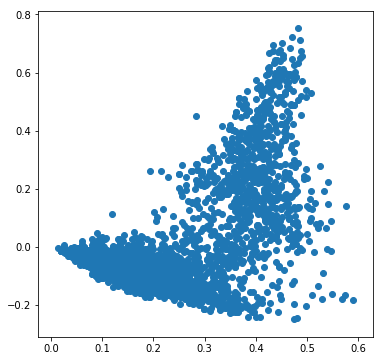

In [77]:
plt.figure(figsize=(6,6))
plt.scatter(city_load_df[0], city_load_df[1], color=color_list)
#plt.scatter(city_load_df[0], city_load_df[1], color=color_list)
plt.xlabel('Topic 1')
plt.xlabel('Topic 2')

In [50]:
city_inds = np.array(np.array(city_load)[:,0], dtype=int)
city_list = np.array(cities)[city_inds]

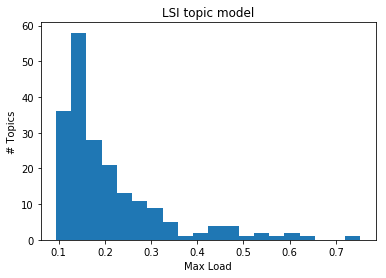

In [51]:
plt.hist(city_load_df.max(axis=0), bins=20);
plt.title('LSI topic model');
plt.ylabel('# Topics');
plt.xlabel('Max Load');

In [52]:
city_load_mat = city_load_df.T.corr()
print(city_load_mat.shape)

(6815, 6815)


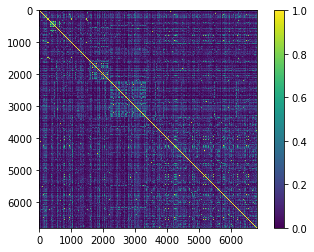

In [55]:
plt.imshow(city_load_mat, interpolation='nearest')
plt.clim(0,1)
plt.colorbar()

In [ ]:
#overlap_df = pd.read_excel('%s/overlap_poi_categories_by_city.xlsx' % (datadir))

In [ ]:
#norm_overlap_df = pd.read_excel('%s/norm_overlap_poi_categories_by_city.xlsx' % (datadir))

In [34]:
def compare_lsi_loads(category):
    category_mask = np.array(city_categories[category], dtype=bool)
    T_cities = city_categories.index[category_mask]
    F_cities = city_categories.index[~category_mask]
    T_loads = city_load_df.loc[T_cities]
    F_loads = city_load_df.loc[F_cities]

In [ ]:
for c in communities_set:
    c_inds = list(city_categories.index[c])
    city_categories.All_categories.loc[c_inds]

## By POI

In [312]:
poi_df = tokenize_text_from_df(poi_df, out_col='Article_tokens_noStopwords', stopwords=True)

In [313]:
poi_df.head()

,Name,Location,Article_content,Article_tokens,Article_tokens_noStopwords
Location,,,,,
"Montgomery, Alabama",Building 800--Austin Hall,"Montgomery, Alabama",Building 800–Austin Hall is located in Montgom...,"[building, austin, hall, is, located, in, mont...","[building, austin, hall, located, montgomery, ..."
"Montgomery, Alabama",Building 836--Community College of the Air For...,"Montgomery, Alabama",Simler Hall (also known as Building 836) is th...,"[simler, hall, also, known, as, building, is, ...","[simler, hall, also, known, building, oldest, ..."
"Montgomery, Alabama",Maxwell Air Force Base Senior Officer's Quarte...,"Montgomery, Alabama",The Maxwell Air Force Base Senior Officer's Qu...,"[the, maxwell, air, force, base, senior, offic...","[maxwell, air, force, base, senior, officer, q..."
"Chandler, Arizona",Midvale Archeological Site,"Chandler, Arizona",This is a list of the National Register of His...,"[this, is, a, list, of, the, national, registe...","[list, national, register, historic, places, l..."
"Mesa, Arizona",Ammo Bunker (S-1007),"Mesa, Arizona",Williams Air Force Base is a former United Sta...,"[williams, air, force, base, is, a, former, un...","[williams, air, force, base, former, united, s..."


# Formatting data

In [34]:
def get_article_content_by_city(city, df, lower=False):
    city_mask = df.Location == city
    try:
        tmp_content = list(df.loc[city_mask].Article_content)
        text = (' ').join(tmp_content)
        if lower:
            return clean_text(text)
        else:
            return clean_text(text, lower=lower)
    except:
        return ''

In [35]:
city_articles = []
for city in poi_by_city_df.Location.unique():
    tmp_article = get_article_content_by_city(city, poi_df)
    city_articles.append([city, tmp_article])

NameError: name 'city_articles' is not defined

In [ ]:
poi_by_city_df.Article_content = city_articles

In [10]:
def remove_proper_nouns(raw_text, lower=True):
    text = tokenize_text(raw_text, lower=False)
    tagged_text = nltk.pos_tag(text)
    edited_text = [word for word, tag in tagged_text if tag != 'NNP' and tag != 'NNPS']
    output = ' '.join(edited_text)
    if lower:
        return clean_text(output)
    else:
        return output

In [61]:
fhp_df_f = '%s/federal_historic_places_by_city_for_nlp.xlsx' % (datadir)
fhp_df = pd.read_excel(fhp_df_f, index_col=0)
#fhp_df = fhp_df.drop_duplicates()
#fhp_df.to_excel(fhp_df_f)

In [62]:
park_df_f = '%s/parks_by_city_for_nlp.xlsx' % (datadir)
park_df = pd.read_excel(park_df_f, index_col=0)
#park_df = park_df.drop_duplicates()
#park_df.to_excel(park_df_f)

In [63]:
museum_df_f = '%s/museums_by_city_for_nlp.xlsx' % (datadir)
museum_df = pd.read_excel(museum_df_f, index_col=0)
#museum_df = museum_df.drop_duplicates()
#museum_df.to_excel(museum_df_f)

In [64]:
poi_df = pd.concat([fhp_df, park_df, museum_df])
#poi_df  = poi_df.reset_index()
print(poi_df.shape)
poi_df.head()

(24066, 4)


,Name,Location,Article_content,Article_tokens
0,Building 800--Austin Hall,"Montgomery, Alabama",Building 800–Austin Hall is located in Montgom...,"['building', 'austin', 'hall', 'is', 'located'..."
1,Building 836--Community College of the Air For...,"Montgomery, Alabama",Simler Hall (also known as Building 836) is th...,"['simler', 'hall', 'also', 'known', 'as', 'bui..."
2,Maxwell Air Force Base Senior Officer's Quarte...,"Montgomery, Alabama",The Maxwell Air Force Base Senior Officer's Qu...,"['the', 'maxwell', 'air', 'force', 'base', 'se..."
3,Midvale Archeological Site,"Chandler, Arizona",This is a list of the National Register of His...,"['this', 'is', 'a', 'list', 'of', 'the', 'nati..."
4,Ammo Bunker (S-1007),"Mesa, Arizona",Williams Air Force Base is a former United Sta...,"['williams', 'air', 'force', 'base', 'is', 'a'..."


In [194]:
rm_inds = []
for i, text in enumerate(poi_df.Article_content):
    try:
        if 'This list of' in text[:12]:
            rm_inds.append(i)
        elif 'This is a list of' in text[:17]:
            rm_inds.append(i)
        elif 'An ' == text[:3]:
            check_inds.append(i)
        elif 'A ' == text[:2]:
            check_inds.append(i)
    except:
        continue

In [195]:
poi_df.Article_content.iloc[rm_inds] = ''
poi_df.Article_tokens.iloc[rm_inds] = ''

In [198]:
cities = poi_df.Location.unique()
article_content_by_city = []
for i, city in enumerate(cities):
    if i % 500 == 0:
        print(i)
    content = get_article_content_by_city(city, poi_df, lower=False)
    article_content_by_city.append([city, content])

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [204]:
poi_by_city_df = pd.DataFrame(np.array([cities, article_content_by_city]).T, columns=['Location', 'Article_content'])
#poi_by_city_df.to_csv(poi_by_city_df_f)

### Article content

In [155]:
nonnp_article_content_by_city = []
for i, city in enumerate(poi_by_city_df.Location):
    if i % 500 == 0:
        print(i, city)
    content = poi_by_city_df.Article_content.iloc[i]
    nonnp_content = remove_proper_nouns(content)
    nonnp_article_content_by_city.append([city, nonnp_content])

0 Montgomery, Alabama
500 Moneta, Wyoming
1000 Matinicus Island, Maine
1500 Chelan, Washington
2000 Pipestone, Minnesota
2500 Garrett, Indiana
3000 Mercersburg, Pennsylvania
3500 Sebring, Florida
4000 Wildwood, Missouri
4500 Antimony, Utah
5000 Salem, Connecticut
5500 Rossville, Illinois
6000 Carrollton, Kentucky
6500 Portage, Michigan
7000 Mexico, Missouri
7500 Southampton, New Jersey
8000 Mount Olive, North Carolina
8500 Confederated Tribesof Grand Ronde, Oregon
9000 Ethridge, Tennessee
9500 Bedford, Virginia


## Federal historic landmarks

### By city

In [35]:
fhp_df = fhp_df.fillna('')

In [19]:
#fhp_cities = fhp_df.Location.unique()

~~~
article_content_by_city = []
for city in fhp_cities:
    content = get_article_content_by_city(city, fhp_df)
    article_content_by_city.append([city, content])
~~~

In [38]:
fhp_df = tokenize_text_from_df(fhp_df)

In [40]:
fhp_df.head()

,Name,Location,Article_content,Article_tokens
0,Building 800--Austin Hall,"Montgomery, Alabama",Building 800–Austin Hall is located in Montgom...,"[building, austin, hall, is, located, in, mont..."
1,Building 836--Community College of the Air For...,"Montgomery, Alabama",Simler Hall (also known as Building 836) is th...,"[simler, hall, also, known, as, building, is, ..."
2,Maxwell Air Force Base Senior Officer's Quarte...,"Montgomery, Alabama",The Maxwell Air Force Base Senior Officer's Qu...,"[the, maxwell, air, force, base, senior, offic..."
3,Midvale Archeological Site,"Chandler, Arizona",This is a list of the National Register of His...,"[this, is, a, list, of, the, national, registe..."
4,Ammo Bunker (S-1007),"Mesa, Arizona",Williams Air Force Base is a former United Sta...,"[williams, air, force, base, is, a, former, un..."


In [42]:
fhp_df.to_excel('%s/federal_historic_places_by_city_for_nlp.xlsx' % (datadir))

## Parks

In [49]:
park_df = park_df[['Park', 'Location', 'Article_content', 'Article_tokens']]
park_df.columns = ['Name', 'Location', 'Article_content', 'Article_tokens']
park_df.to_excel('%s/parks_by_city_for_nlp.xlsx' % (datadir))

In [5]:
park_df.loc[park_df.Park == 'Tuskegee National Forest'].Article_tokens.values

array(["['the', 'tuskegee', 'national', 'forest', 'is', 'a', 'u', 's', 'national', 'forest', 'located', 'in', 'macon', 'county', 'alabama', 'just', 'north', 'of', 'tuskegee', 'and', 'west', 'of', 'auburn', 'the', 'topography', 'is', 'level', 'to', 'moderately', 'sloping', 'with', 'broad', 'ridges', 'with', 'stream', 'terraces', 'and', 'broad', 'floodplains', 'tuskegee', 'national', 'forest', 'is', 'the', 'smallest', 'national', 'forest', 'in', 'the', 'u', 's', 'and', 'one', 'of', 'only', 'six', 'that', 'is', 'contained', 'entirely', 'within', 'a', 'single', 'county', 'but', 'supports', 'many', 'outdoor', 'activities', 'the', 'forest', 'is', 'headquartered', 'in', 'montgomery', 'as', 'are', 'all', 'four', 'of', 'alabama', 's', 'national', 'forests', 'the', 'other', 'national', 'forests', 'in', 'the', 'state', 'are', 'conecuh', 'talladega', 'and', 'william', 'b', 'bankhead', 'there', 'are', 'local', 'ranger', 'district', 'offices', 'located', 'in', 'tuskegee', 'outdoor', 'activities', 't

In [6]:
park_line_list = []
for line in park_df['Article_tokens']:
    try:
        line = literal_eval(line)
        park_line_list.append(line)
    except:
        continue
len(park_line_list)

3451

In [7]:
park_dictionary = corpora.Dictionary(park_line_list)

In [8]:
once_ids = [tokenid for tokenid, docfreq in park_dictionary.dfs.items() if docfreq == 1]
park_dictionary.filter_tokens(once_ids)
park_dictionary.compactify()

Create a sparse vector of integer words ids to word counts for each museum and a TF-IDF model (i.e. term frequency–inverse document frequency). The TF-IDF model converts raw word counts to a value reflecting the importance of each word given the corpus.

In [10]:
park_corpus = [park_dictionary.doc2bow(words) for words in park_line_list]
corpora.mmcorpus.MmCorpus.serialize('%s/wiki_museums.mm' % (datadir), park_corpus)
park_tfidf = models.TfidfModel(park_corpus)

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
park_lsi = models.lsimodel.LsiModel(corpus=park_tfidf[park_corpus], id2word=park_dictionary)
park_lsi.save('%s/wiki_museums.lsi' % (datadir))

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
for i, topic in enumerate(park_lsi.print_topics(5)[:5]):
    print('Topic {}:'.format(i))
    print(topic)
    print('')

Topic 0:
(0, '0.303*"refuge" + 0.195*"forest" + 0.152*"wildlife" + 0.142*"lake" + 0.127*"national" + 0.111*"park" + 0.100*"island" + 0.089*"fort" + 0.086*"river" + 0.084*"creek"')

Topic 1:
(1, '-0.742*"refuge" + -0.265*"wildlife" + 0.154*"forest" + 0.094*"park" + -0.089*"habitat" + 0.084*"fort" + -0.077*"birds" + -0.074*"waterfowl" + -0.070*"species" + -0.068*"fish"')

Topic 2:
(2, '-0.618*"forest" + 0.381*"fort" + 0.181*"oregon" + -0.164*"wilderness" + 0.148*"island" + -0.126*"forests" + 0.109*"beach" + 0.104*"washington" + 0.096*"columbia" + -0.093*"connecticut"')

Topic 3:
(3, '-0.513*"oregon" + -0.359*"fort" + -0.339*"forest" + -0.168*"columbia" + -0.168*"retrieved" + 0.164*"lake" + -0.132*"national" + -0.120*"wilderness" + -0.120*"clark" + -0.111*"lewis"')

Topic 4:
(4, '-0.553*"oregon" + 0.521*"fort" + -0.129*"lake" + -0.128*"illinois" + 0.120*"forest" + -0.110*"recreation" + -0.108*"retrieved" + -0.107*"parks" + -0.096*"department" + -0.093*"administered"')



In [15]:
park_matsim = similarities.MatrixSimilarity(park_lsi[park_tfidf[park_corpus]], num_best=10)

In [16]:
parks = list(park_df.Park.values)

In [17]:
for sims in list(park_matsim)[:5]:
    index = sims[0][0]
    print(parks[index])
    for other_index, score in sims[1:]:
        print('\t%s|%.2f' % (parks[other_index], score))

Bladon Springs State Park
	Emerald Lake State Park|0.67
	Stephens State Park|0.65
	Wilmington State Park|0.65
	Table Rock State Park|0.62
	Old Santee Canal State Park|0.62
	Cloudland Canyon State Park|0.61
	General Coffee State Park|0.61
	Ocala National Forest|0.61
	Monte Sano State Park|0.59
Cockaponset State Forest
	Blue Springs State Park|1.00
	Charlotte Harbor State Park|0.80
	Cedar Key Museum State Park|0.79
	Caladesi Island State Park|0.77
	Blackwater River State Park|0.77
	Gasparilla Island State Park|0.63
	Killens Pond State Park|0.59
	Grayton Beach State Park|0.56
	Fort George Island Cultural State Park|0.56
Chattahoochee State Park
	Wind Creek State Park|0.83
	Lake Lurleen State Park|0.83
	Monte Sano State Park|0.80
	Chewacla State Park|0.78
	De Soto State Park|0.73
	Roland Cooper State Park|0.73
	Little River State Forest|0.73
	Cheaha State Park|0.73
	Paul M Grist State Park|0.71
Cheaha State Park
	Cheaha State Park|1.00
	Wheeler National Wildlife Refuge|1.00
	Cheaha State P

## Wiki museums

In [36]:
len(wiki_museum_df.City.unique())

5769

In [35]:
wiki_museum_df.Category.unique()

array(['Law', 'Art', 'Living history', 'History', 'Historic house',
       'Radio', 'Music', 'Industry', 'Medical', 'Natural history',
       'Multiple', 'Sports', 'Capitol', 'Military', 'Mining',
       'Local history', 'Religious', 'Automotive',
       'History\xa0/ African\xa0American', 'Railroad', 'Decorative arts',
       'African\xa0American', "Children's", 'Biographical', 'Science',
       'Native\xa0American', 'Transportation',
       'Sports /History\xa0/ African\xa0American', 'Native American',
       'Open-air', 'Firefighting', 'website', 'Aviation', 'Aerospace',
       'Alaskan Native', 'Law enforcement', "Alaska's Military History",
       'Technology', 'Maritime', 'History - Local',
       'Ethnic - Native American', 'Toy', 'Scouting', 'Archaeology',
       'Hall of fame - Sports', 'Geology', 'History / Geology', 'Jewish',
       'American West', 'Prison', 'School', 'Anthropology', 'Automobile',
       'Doll', 'Military - United States', 'History - local',
       'Philate

In [32]:
wiki_museum_df.head()

,Name,Category,City,State,Article_content,Region,County,Summary,Notes,Article_tokens
0,Alabama Administrative Office of Courts Museum...,Law,Montgomery,Alabama,NaN,Central,Montgomery,Exhibits of Alabama judicial history and impor...,NaN,NaN
1,Alabama Artists Gallery,Art,Montgomery,Alabama,"Fred Nall Hollis (born April 21, 1948) is an i...",Central,Montgomery,Operated by the Alabama State Council on the A...,NaN,"['fred', 'nall', 'hollis', 'born', 'april', 'i..."
2,Alabama Constitution Village,Living history,Huntsville,Alabama,The Constitution Hall Park is a historical ope...,Northern,Madison,Open-air museum that reenacts life in 1819.[2],NaN,"['the', 'constitution', 'hall', 'park', 'is', ..."
3,Alabama Department of Archives and History,History,Montgomery,Alabama,The Alabama Department of Archives and History...,Central,Montgomery,"Official archives for the state of Alabama, fe...",NaN,"['the', 'alabama', 'department', 'of', 'archiv..."
4,Alabama Governor's Mansion,Historic house,Montgomery,Alabama,The Alabama Governor's Mansion is the official...,Central,Montgomery,Official residence of Alabama's Governor. Open...,NaN,"['the', 'alabama', 'governor', 's', 'mansion',..."


In [22]:
museum_line_list = []
for line in wiki_museum_df['Article_tokens']:
    try:
        line = literal_eval(line)
        museum_line_list.append(line)
    except:
        continue
len(museum_line_list)

23081

In [23]:
museum_dictionary = corpora.Dictionary(museum_line_list)

In [24]:
once_ids = [tokenid for tokenid, docfreq in museum_dictionary.dfs.items() if docfreq == 1]
museum_dictionary.filter_tokens(once_ids)
museum_dictionary.compactify()

Create a sparse vector of integer words ids to word counts for each museum and a TF-IDF model (i.e. term frequency–inverse document frequency). The TF-IDF model converts raw word counts to a value reflecting the importance of each word given the corpus.

In [25]:
museum_corpus = [museum_dictionary.doc2bow(words) for words in museum_line_list]
corpora.mmcorpus.MmCorpus.serialize('%s/wiki_museums.mm' % (datadir), museum_corpus)
museum_tfidf = models.TfidfModel(museum_corpus)

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [26]:
museum_lsi = models.lsimodel.LsiModel(corpus=museum_tfidf[museum_corpus], id2word=museum_dictionary)
museum_lsi.save('%s/wiki_museums.lsi' % (datadir))

/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/klarnemann/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [27]:
for i, topic in enumerate(museum_lsi.print_topics(5)[:5]):
    print('Topic {}:'.format(i))
    print(topic)
    print('')

Topic 0:
(0, '0.392*"museums" + 0.223*"closed" + 0.144*"alphabetical" + 0.143*"click" + 0.137*"museum" + 0.136*"column" + 0.112*"list" + 0.099*"utah" + 0.095*"art" + 0.092*"category"')

Topic 1:
(1, '-0.331*"museums" + -0.166*"closed" + -0.161*"alphabetical" + -0.160*"click" + -0.146*"column" + -0.110*"utah" + 0.096*"were" + -0.091*"category" + 0.085*"york" + 0.083*"was"')

Topic 2:
(2, '0.358*"utah" + -0.313*"york" + -0.188*"society" + -0.149*"closed" + 0.138*"age" + -0.133*"documents" + -0.128*"new" + -0.116*"art" + 0.115*"population" + -0.111*"counties"')

Topic 3:
(3, '0.581*"utah" + -0.234*"closed" + 0.202*"york" + 0.134*"category" + 0.130*"society" + 0.122*"documents" + 0.122*"riverton" + -0.101*"chicago" + 0.094*"vol" + 0.091*"roy"')

Topic 4:
(4, '-0.213*"york" + -0.210*"age" + -0.178*"counties" + -0.170*"population" + -0.154*"median" + -0.153*"census" + -0.147*"county" + -0.145*"households" + 0.137*"michigan" + -0.128*"income"')



In [28]:
museum_matsim = similarities.MatrixSimilarity(museum_lsi[museum_tfidf[museum_corpus]], num_best=10)

In [29]:
museums = list(wiki_museum_df.Name.values)

In [30]:
for sims in list(museum_matsim)[:5]:
    index = sims[0][0]
    print(museums[index])
    for other_index, score in sims[1:]:
        print('\t%s|%.2f' % (museums[other_index], score))

Museum of Geology
	Alabama Administrative Office of Courts Museum Area|1.00
	Evansville Historical Foundation|0.83
	Old Lighthouse Museum|0.83
	Indian Mound and Museum|0.83
	Bradley Academy Museum and Cultural Center|0.83
	Museum of Wildlife, Science and Industry of NE South Dakota|0.81
	Alabama Constitution Village|0.81
	Porter Sculpture Park|0.81
	Alabama Veterans Museum and Archives|0.81
Conde-Charlotte House
	Alabama Artists Gallery|1.00
	Verendrye Museum|1.00
	Museum of Visual Materials|1.00
	Alabama Veterans Museum and Archives|0.85
	Porter Sculpture Park|0.85
	Mobile Carnival Museum|0.84
	Clement Railroad Hotel Museum|0.84
	Alabama Constitution Village|0.82
	Museum of Wildlife, Science and Industry of NE South Dakota|0.82
Museum of Wildlife, Science and Industry of NE South Dakota
	Alabama Constitution Village|1.00
	Porter Sculpture Park|0.87
	Alabama Veterans Museum and Archives|0.87
	Clement Railroad Hotel Museum|0.85
	Mobile Carnival Museum|0.85
	Indian Mound and Museum|0.83


# Tokenizing

## Wikipedia Museum Listings

In [11]:
wiki_museum_df_f = '%s/clean_scraped_wikipedia_tables_museums.csv' % (datadir)

In [5]:
wiki_museum_df = pd.read_csv(wiki_museum_df_f, index_col=0)

In [6]:
wiki_museum_df.head()

,Name,Category,City,State,Article_content,Region,County,Summary,Notes
0,Alabama Administrative Office of Courts Museum...,Law,Montgomery,Alabama,NaN,Central,Montgomery,Exhibits of Alabama judicial history and impor...,NaN
1,Alabama Artists Gallery,Art,Montgomery,Alabama,"Fred Nall Hollis (born April 21, 1948) is an i...",Central,Montgomery,Operated by the Alabama State Council on the A...,NaN
2,Alabama Constitution Village,Living history,Huntsville,Alabama,The Constitution Hall Park is a historical ope...,Northern,Madison,Open-air museum that reenacts life in 1819.[2],NaN
3,Alabama Department of Archives and History,History,Montgomery,Alabama,The Alabama Department of Archives and History...,Central,Montgomery,"Official archives for the state of Alabama, fe...",NaN
4,Alabama Governor's Mansion,Historic house,Montgomery,Alabama,The Alabama Governor's Mansion is the official...,Central,Montgomery,Official residence of Alabama's Governor. Open...,NaN


In [7]:
wiki_museum_df = tokenize_text_from_df(wiki_museum_df)

In [12]:
wiki_museum_df.head()

,Name,Category,City,State,Article_content,Region,County,Summary,Notes,Article_tokens
0,Alabama Administrative Office of Courts Museum...,Law,Montgomery,Alabama,NaN,Central,Montgomery,Exhibits of Alabama judicial history and impor...,NaN,
1,Alabama Artists Gallery,Art,Montgomery,Alabama,"Fred Nall Hollis (born April 21, 1948) is an i...",Central,Montgomery,Operated by the Alabama State Council on the A...,NaN,"[fred, nall, hollis, born, april, is, an, inte..."
2,Alabama Constitution Village,Living history,Huntsville,Alabama,The Constitution Hall Park is a historical ope...,Northern,Madison,Open-air museum that reenacts life in 1819.[2],NaN,"[the, constitution, hall, park, is, a, histori..."
3,Alabama Department of Archives and History,History,Montgomery,Alabama,The Alabama Department of Archives and History...,Central,Montgomery,"Official archives for the state of Alabama, fe...",NaN,"[the, alabama, department, of, archives, and, ..."
4,Alabama Governor's Mansion,Historic house,Montgomery,Alabama,The Alabama Governor's Mansion is the official...,Central,Montgomery,Official residence of Alabama's Governor. Open...,NaN,"[the, alabama, governor, s, mansion, is, the, ..."


In [14]:
wiki_museum_df.to_csv(wiki_museum_df_f)

### Across all articles in wiki_museum_df

In [8]:
museum_text_list = list(np.array(wiki_museum_df['Article_content'], dtype=str))
museum_text = (' ').join(museum_text_list)

In [9]:
clean_museum_text = clean_text(museum_text)

In [10]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
museum_ttext = tokenizer.tokenize(clean_museum_text)

## Parks

In [9]:
park_df = pd.read_excel('%s/scraped_parks.xlsx' % (datadir), index_col=0)

In [10]:
park_df.head()

,Park,State,City,Street Address,Url,Category,Features,Description,Article_content
0,Bladon Springs State Park,Alabama,Silas,3921 Bladon Rd,https://www.stateparks.com/bladon_springs_stat...,State Park,"['Camping', 'Nearby Parks', 'Picnicking', 'Cur...","Centering around four mineral springs, this 3...",Bladon Springs State Park is a locally managed...
1,Blue Springs State Park,Alabama,Clio,2595 AL-10,https://www.stateparks.com/blue_springs_state_...,State Park,"['Camping', 'Swimming', 'Fishing', 'Picnicking...","Fed by a crystal-clear underground spring, th...",Blue Spring State Park is a state park located...
2,Chattahoochee State Park,Alabama,Gordon,250 Chattahoochee St Pk Rd,https://www.stateparks.com/chattahoochee_state...,State Park,"['Nearby Parks', 'Current Weather Prediction']",,"Chattahoochee State Park is a state-owned, pub..."
3,Cheaha State Park,Alabama,Delta,19644 AL-281,https://www.stateparks.com/cheaha_state_park_i...,State Park,"['History of the Area', 'Meeting Rooms', 'Cabi...","Located in Clay and Cleburne Counties, Cheaha...",Cheaha State Park is a publicly owned recreati...
4,Chewacla State Park,Alabama,Auburn,124 Shell Toomer Pkwy,https://www.stateparks.com/chewacla_state_park...,State Park,"['Cabins', 'Camping', 'Swimming', 'Boating', '...",Chewacla State Park's 696 scenic acres are a ...,Chewacla State Park is a publicly owned recrea...


In [84]:
park_df['Article_tokens'] = ''

In [66]:
text = park_df.loc[4, 'Article_content']
text

"Chewacla State Park is a publicly owned recreation area in Auburn, Lee County, Alabama, occupying 696 acres (282 ha) to the south of Interstate 85. The state park's central feature, 26-acre (11 ha) Lake Chewacla, provides opportunities for fishing, swimming, and non-motorized boating.\n\n\n== History ==\nIn the late nineteenth century, Wright's Mill occupied a site in the park where swimmers could find a place to splash about in the mill's surrounding pool. In the 1930s, workers with the Civilian Conservation Corps developed roads, foot trails, and park buildings. Their efforts can be seen in the park's stone cabins and arched masonry bridge. They also constructed the dam that created Chewacla Lake. The state took possession, opening the grounds as Chewacla State Park, in 1939.\n\n\n== Activities and amenities ==\nIn addition to water activities, the park features a system of trails for hiking and for mountain biking. The park has facilities for RV and tent camping in addition to its 

In [76]:
park_text_list = list(np.array(park_df['Article_content'], dtype=str))
park_text = (' ').join(park_text_list)

In [80]:
clean_park_text = clean_text(park_text)

In [83]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
park_ttext = tokenizer.tokenize(clean_park_text)

In [85]:
n_rows, n_cols = park_df.shape

In [97]:
for i in np.arange(n_rows):
    raw_text = park_df.loc[i, 'Article_content']
    if type(raw_text) == float:
        continue
    text = clean_text(raw_text)
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    ttext = tokenizer.tokenize(text)
    park_df.loc[i, 'Article_tokens'] = ttext

In [101]:
park_df.to_excel('%s/scraped_parks.xlsx' % (datadir))

# Notes

In [ ]:
import nltk
import spacy
from gensim import corpora, models, similarities
from collections import defaultdict
#spacy.load('en')
#from spacy.lang.en import English
#parser = English()

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [ ]:

def get_topic_model(tfidf,corpus,dictionary,num_topics,model):

    # Num topics, is the dimensionality.
    # We reduce the dimension from words to a given number of topics
    topic_model = model(tfidf[corpus], id2word=dictionary, num_topics=num_topics)
    
    # To see topics uncomment:
    #for topic in topic_model.print_topics(5):
        #print('Topic: {}'.format(topic[0]))
        #print(str(topic).replace(' + ', '\n')) 
        #print('') 
return topic_model

In [ ]:
import nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')

df_token=df['text_raw']

# Convert to lower case:
for index in df_token.index:
    text=df_token[index]
    df_token[index]=text.lower()

# Tokenize
df_token=df_token.apply(tokenizer.tokenize)
df_token.head()

In [ ]:
# make gensim dictionary

line_list = df_token.values
dictionary = corpora.Dictionary(line_list)
# dictionary: 0: "about", 1:"shelter",...

# filter dictionary to remove stopwords and words occurring < min_count times
# need to run nltk.download() -> 3 GB downloaded into C:\Users\melanie\AppData\Roaming\nltk_data
stop_words = nltk.corpus.stopwords.words('english') 
print("Stop words: {}\n".format(stop_words[:5]))

stop_ids = [dictionary.token2id[word] for word in stop_words
            if word in dictionary.token2id]
min_count = 2
rare_ids = [id for id, freq in dictionary.dfs.items()
            if freq < min_count]
dictionary.filter_tokens(stop_ids + rare_ids)
print("Dictionary after filtering:")
print([(key,dictionary[key]) for key in dictionary.keys()[1:5]])
dictionary.compactify()